### Dataset by:
```
@misc{rozemberczki2021twitch,
      title={Twitch Gamers: a Dataset for Evaluating Proximity Preserving and Structural Role-based Node Embeddings}, 
      author={Benedek Rozemberczki and Rik Sarkar},
      year={2021},
      eprint={2101.03091},
      archivePrefix={arXiv},
      primaryClass={cs.SI}
}
```

### Social Network Analysis of Twitch Partners
A social network of Twitch users which was collected from the public API in Spring 2018. Nodes are Twitch users and edges are mutual follower relationships between them. The graph forms a single strongly connected component without missing attributes. The machine learning tasks related to the graph are count data regression and node classification.

In [1]:
import networkx as nx   
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Netzwerk einlesen und in NetworkX abbilden

In [2]:
# Netzwerk einlesen
fh = open("data/large_twitch_edges.csv", "rb")
G = nx.read_edgelist(fh, delimiter=',')
fh.close()

In [3]:
# Remove header nodes
G.remove_node('numeric_id_1')
G.remove_node('numeric_id_2')

### Manuelle Überprüfung, ob das Netz korrekt eingelesen wurde

In [4]:
edge_list = pd.read_csv('data/large_twitch_edges.csv').astype(str)
edge_list.head()

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118


In [5]:
# Überprüfung, ob die Nachbarn von 98343 korrekt abgebildet wurden.
assert set(G.neighbors('98343')) == set(edge_list[edge_list.numeric_id_1=='98343'].numeric_id_2), "Neighbors of 98343 are not correct."

## EDA auf Knotenattributen und Netzwerkgrösse
### Netzwerkgrösse

In [6]:
print(f'Anzahl Knoten: {G.number_of_nodes()}')
print(f'Anzahl Kanten: {G.number_of_edges()}')
print(f'Density: {nx.density(G)}')

Anzahl Knoten: 168114
Anzahl Kanten: 6797557
Density: 0.00048103610439398153


Wir haben es also mit einem sehr grossen Netzwerk zu tun, welches aber wenig Kanten hat im Vergleich mit der Anzahl Knoten. Dies ergibt soweit Sinn, da eine Kante nur entsteht, wenn sich User gegenseitig followen. User, welche fast nur anderen zuschauen, werden wohl wenig Kanten haben, da diese eher selten gefollowed werden. Wir werden das Netzwerk nach gewissen Knotenattributen filtern, um die Prozessierung zu ermöglichen. 

### Knotenattribute

In [7]:
features = pd.read_csv('data/large_twitch_features.csv')
features.numeric_id = features.numeric_id.astype(str)

In [8]:
features.columns

Index(['views', 'mature', 'life_time', 'created_at', 'updated_at',
       'numeric_id', 'dead_account', 'language', 'affiliate'],
      dtype='object')

Der Datensatz hat folgende Attribute:
- `views`: Anzahl Views auf dem User / Channel
- `mature`: Ob der Channel sich an Erwachsene richtet.
- `life_time`: Anzahl Tage zwischen erstem Stream und letztem Stream.
- `created_at`: Wann der User erstellt wurde
- `updated_at`: Wann der User das letzte mal gestreamed hat.
- `numeric_id`: Unique ID des Users
- `dead_account`: Ob der Account deaktiviert wurde oder der User lange nicht aktiv war (~3 Monate)
- `language`: Sprache des Users / Channel
- `affiliate`: Ob der User ein Twitchpartner ist.


In [9]:
features.isna().sum()

views           0
mature          0
life_time       0
created_at      0
updated_at      0
numeric_id      0
dead_account    0
language        0
affiliate       0
dtype: int64

Im vorherigen Kapitel haben wir die Annahme getroffen, dass Twitch-Partner mehr Kanten haben als nicht-Partner. Wir können uns die Density von den zwei Subgruppen anschauen.

In [10]:
netzwerk_partner = nx.subgraph(G, features[features.affiliate==True].numeric_id.tolist())
netzwerk_kein_partner = nx.subgraph(G, features[features.affiliate==False].numeric_id.tolist())

In [11]:
print(f'Density von Nicht-Partnern: {nx.density(netzwerk_kein_partner)}')

Density von Nicht-Partnern: 0.0006154880996428399


In [12]:
print(f'Density von Partnern: {nx.density(netzwerk_partner)}')

Density von Partnern: 0.0004175468251946277


Das war nicht erwartet; Die Density von nicht-Partnern ist ca. 50% höher als von Partnern. Dies bedeutet, dass sich nicht-Partnern gegenseitiger häufiger folgen als Partner. Ändern sich diese Zahlen, wenn wir inaktive Accounts rausnehmen?

In [13]:
netzwerk_aktiv = nx.subgraph(G, features[features.dead_account==False].numeric_id.tolist())
netzwerk_aktiv_partner = nx.subgraph(netzwerk_aktiv, features[features.affiliate==True].numeric_id.tolist())
netzwerk_aktiv_kein_partner = nx.subgraph(netzwerk_aktiv, features[features.affiliate==False].numeric_id.tolist())

In [14]:
print(f'Density von aktiven Nicht-Partnern: {nx.density(netzwerk_aktiv_kein_partner)}')

Density von aktiven Nicht-Partnern: 0.0006735701234769484


In [15]:
print(f'Density von aktiven Partnern: {nx.density(netzwerk_aktiv_partner)}')

Density von aktiven Partnern: 0.00041792783234412354


Die Density nimmt zu, bei beiden, aber mehr bei den nicht-Partnern. Ergibt auch Sinn, da Partner wohl im Prinzip nicht inaktiv sein können. Dies lässt sich leicht überprüfen.

In [16]:
print(f"Anteil Partner von inaktiven vs aktiven User:\n{features.groupby('dead_account')['affiliate'].value_counts()}")

Anteil Partner von inaktiven vs aktiven User:
dead_account  affiliate
0             0            81483
              1            81472
1             0             5085
              1               74
Name: affiliate, dtype: int64


Wie erwartet ist der Anteil von inaktiven Accounts bei Partnern tiefer (ca. 70x).

#### Views
Wir schauen uns nun das Attribut `views` an von aktiven Accounts, separat für Partner und nicht-Partner.

In [17]:
active_accounts = features[features.dead_account==False]
views_active_no_partner = active_accounts[active_accounts.affiliate==False].views
views_active_partner = active_accounts[active_accounts.affiliate==True].views

In [26]:
# Print mean and median for views of active accounts without partner and with partner
print(f"Mean views of active accounts without partner: {views_active_no_partner.mean():.2f}")
print(f"Mean views of active accounts with partner: {views_active_partner.mean():.2f}")
print(f"Median views of active accounts without partner: {views_active_no_partner.median():.2f}")
print(f"Median views of active accounts with partner: {views_active_partner.median():.2f}")

Mean views of active accounts without partner: 364752.97
Mean views of active accounts with partner: 23299.74
Median views of active accounts without partner: 1945.00
Median views of active accounts with partner: 7469.00


Sehr interessant! Wieder unerwartet. Im Durchschnitt hat ein Partner ca. 15x mehr Views als Nicht-Partner. Wenn wir uns aber den Median anschauen, ist das Bild anders; hier hat ein Partner im Median ca. 4x soviele Views. Es scheint so, als hätten Nicht-Partner massive Aussreisser in den Views. Dies können wir mit einem Boxplot bestätigen:

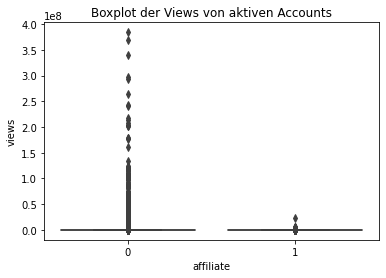

In [31]:
sns.boxplot(x='affiliate', y='views', data=active_accounts)
plt.title('Boxplot der Views von aktiven Accounts')
plt.show()

Wir können uns noch die Top 30 anschauen und sehen, dass von den Top 30 Views niemand gepartnert ist mit Twitch.

In [42]:
active_accounts.sort_values(by='views', ascending=False).head(30)

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
96473,384396587,0,2416,2012-03-01,2018-10-12,96473,0,RU,0
129896,368912220,0,2379,2012-04-07,2018-10-12,129896,0,EN,0
61862,340602050,0,2826,2011-01-16,2018-10-12,61862,0,EN,0
128864,297117159,0,2314,2012-06-11,2018-10-12,128864,0,EN,0
144643,294116493,0,2577,2011-09-22,2018-10-12,144643,0,EN,0
110345,264643346,0,2664,2011-06-27,2018-10-12,110345,0,EN,0
125642,243451177,0,2507,2011-12-01,2018-10-12,125642,0,EN,0
64605,240718261,1,2516,2011-11-22,2018-10-12,64605,0,EN,0
71050,218559516,0,2169,2012-11-03,2018-10-12,71050,0,EN,0
161362,213931993,0,2359,2012-04-27,2018-10-12,161362,0,EN,0


Eine gute Erklärung habe ich dafür nicht, es wäre aber Möglich, über das Datum der Usererstellung ein Mapping zu machen zwischen der uniquen ID und dem richtigen Namen und dann mehr herausfinden zu können, warum die Channels mit den meisten User von nicht-Partnern sind.

Beispiel [Tyler1](https://twitchtracker.com/loltyler1):

- Tyler1 hat seinen User am 14.11.2013 erstellt.
- Er spricht Englisch.
- Er war da wohl wahrscheinlich schon Partner.
- Er hatte Ende 2018 mehr als 80 Millionen Views.


Wir können nun nach diesem User filtern:

In [54]:
active_accounts[
    (active_accounts.created_at=='2013-11-14') &
    (active_accounts.language=='EN') &
    (active_accounts.views > 80000000)
    ]

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
6250,84804681,1,1793,2013-11-14,2018-10-12,6250,0,EN,0


Somit entspricht die `numeric_id` 6250 wohl Tyler1. Gewisse Sachen haben sich aber geändert: Jetzt ist der Channel von Tyler1 nicht mehr an Erwachsene gerichtet. Ebenfalls war er Ende 2018 noch nicht Partner. Ich kann mich aber erinnern, dass Tyler1 [gebannt](https://web.archive.org/web/20190417084311/https://support.riotgames.com/hc/en-us/articles/115013815928-Understanding-ID-Bans) wurde in diesem Zeitrahmen (~2017/18) und danach wurde sein Account wieder freigeschaltet, hat aber wahrscheinlich seinen Partner-Status verloren.